In [1]:
import json
import spotipy
import credentials
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id=credentials.c_id, client_secret=credentials.c_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Lists to store values from search
track_name = []
popularity = []
track_id = []
release_date = []
playlist_num = []

playlists = ['spotify:playlist:7eDUR7lGbiMsAALyxHHIJ5', 'spotify:playlist:0G7caWlbdkLO7gbBeOac2Z']

for i, playlist in enumerate(playlists):
    tracks = sp.playlist_tracks(playlist, limit=100, offset=0, market=None)

    for track in tracks['items']:
        track_name.append(track['track']['name'])
        popularity.append(track['track']['popularity'])
        track_id.append(track['track']['id'])
        release_date.append(track['track']['album']['release_date'])
        playlist_num.append(i)
        

df_tracks = pd.DataFrame({'track_name':track_name, 'track_id':track_id, 'popularity':popularity, 'release_date':release_date, 'playlist_num':playlist_num})
df_tracks.drop_duplicates(subset=['track_name'], inplace=True)
df_tracks['release_date'] = pd.to_datetime(df_tracks['release_date'])

track_features = []
batch_size = 100

for i in range(0, len(df_tracks['track_id']), 100):
    track_batch = df_tracks['track_id'][i:i + batch_size]
    track_features += sp.audio_features(track_batch)

# Load data into dataframe and drop Nan rows
df_features = pd.DataFrame.from_dict(track_features, orient='columns')
df_features = df_features.dropna()

# Drop and rename some columns
columns_to_drop = ['analysis_url','track_href','type','uri']
df_features.drop(columns_to_drop, axis=1,inplace=True)
df_features.rename(columns={'id': 'track_id'}, inplace=True)

# Merge metadata about track with the features of the track
df = pd.merge(df_tracks, df_features, on='track_id', how='inner')
df = df.dropna()

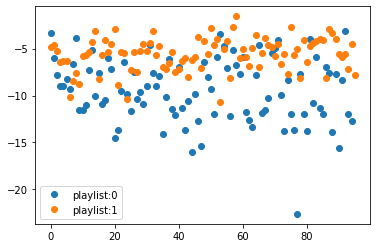

In [4]:
for i in range(len(playlists)):
    plt.plot(range(0, len(df.loc[df['playlist_num'] == i])), df.loc[df['playlist_num'] == i]['loudness'], 'o', label='playlist:' + str(i))
plt.legend()
plt.show()

,track_name,track_id,popularity,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
100,My House,3jomjC6H7YQBRr2CHPtc4y,58,2015-04-07,0.688,0.702,7,-4.792,0,0.0499,0.0215,0.000000,0.1280,0.740,94.006,192191,4
101,Stressed Out,3CRDbSIZ4r5MsZ0YwxuEkn,83,2015-05-15,0.734,0.637,4,-5.677,0,0.1410,0.0462,0.000023,0.0602,0.648,169.977,202333,4
102,NO,0NmeI6UpRE27dxxgosD5n9,15,2016-03-04,0.742,0.809,1,-3.591,0,0.1760,0.0116,0.000003,0.7260,0.632,93.950,213524,4
103,"Me, Myself & I",0KMYgSe9JWHloFeEVBU6qq,11,2015-10-14,0.755,0.686,0,-6.106,0,0.0869,0.0174,0.000000,0.1100,0.386,111.977,252142,4
104,Cake By The Ocean,7L5jgZtAyfiU7elB8DIqCx,14,2015-09-18,0.774,0.748,4,-5.478,0,0.0509,0.1630,0.000000,0.0516,0.914,119.009,218440,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,WTF (Where They From),7IAa7vUJ11STN7le8XaxsH,57,2015-11-12,0.932,0.819,8,-3.484,0,0.2030,0.0181,0.000007,0.0577,0.556,119.941,192773,4
192,Hollow,6SvbLEATKUsqmgscxAj3OQ,2,2015-11-02,0.614,0.654,2,-6.813,0,0.0369,0.0201,0.001560,0.4370,0.408,126.030,210606,4
193,Something New,0PRQlfd2DplZWlitPXww38,0,2016-02-03,0.692,0.774,7,-4.795,1,0.0416,0.0971,0.000000,0.1060,0.380,102.051,212907,4
194,Body,5DZHM6KMuTXl3sJin3b6yx,0,2016-01-22,0.724,0.561,0,-5.912,1,0.0795,0.5780,0.000000,0.0551,0.569,149.992,232720,4
